In [83]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Import & Preparation

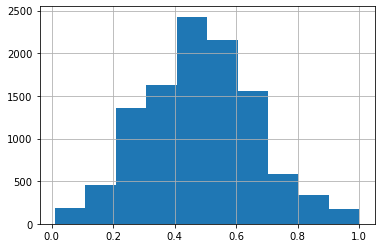

In [84]:
df = pd.read_csv('data.csv').drop_duplicates()
df = df.drop(['raw', 'meditation', 'delta', 'low-gamma', 'mid-gamma'], axis=1)
df.attention = df.attention / 100

df.attention.hist()

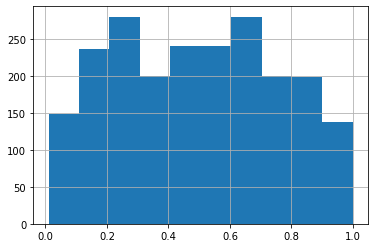

In [85]:
def remove_outliers(df):
    out = pd.DataFrame()
    for att in df.attention.unique():
        tmp_df = df[df.attention == att]
        tmp = []
        for col in tmp_df.columns[1:]:
            Q1 = tmp_df[col].quantile(0.25)
            Q3 = tmp_df[col].quantile(0.75)
            tmp += [(col, Q1, Q3)]
        for col, Q1, Q3 in tmp:
            IQR = Q3 - Q1
            tmp_df = tmp_df[(tmp_df[col] >= Q1 - 1.5 * IQR) & (tmp_df[col] <= Q3 + 1.5 * IQR)]
        out = pd.concat([out, tmp_df])
    return out

def add_features(df):
    for col in df.columns[1:]:
        df[f'log2-{col}'] = np.log2(df[col])
    return df

def prepare_data(df):
    df = remove_outliers(df)
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.groupby(df.attention).head(40)
    df = add_features(df)
    return df

df = prepare_data(df)
df.attention.hist()

In [105]:
def train_val_test_split(df, val_size=0.16, test_size=0.2):
    n = len(df)
    df = df.sample(frac=1).reset_index(drop=True)
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:, 1:])

    val = df.groupby('attention').apply(lambda x: x.head(int(len(x) * val_size))).reset_index(drop=True)
    test = df.groupby('attention').apply(lambda x: x.tail(int(len(x) * test_size))).reset_index(drop=True)
    train = pd.concat([df, val, test]).drop_duplicates(keep=False)

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, :1]
    X_val, y_val = val.iloc[:, 1:], val.iloc[:, :1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, :1]
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1408, 10), (321, 10), (427, 10), (1408, 1), (321, 1), (427, 1))

## Model

In [87]:
def build_model():
    clear_session()
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(1e-2)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [88]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=16, callbacks=[es, reduce_lr], verbose=2)

Epoch 1/1000
88/88 - 0s - loss: 0.2168 - mae: 0.2168 - mse: 0.0648 - val_loss: 0.1834 - val_mae: 0.1834 - val_mse: 0.0502 - lr: 0.0100
Epoch 2/1000
88/88 - 0s - loss: 0.1818 - mae: 0.1818 - mse: 0.0490 - val_loss: 0.1503 - val_mae: 0.1503 - val_mse: 0.0333 - lr: 0.0100
Epoch 3/1000
88/88 - 0s - loss: 0.1725 - mae: 0.1725 - mse: 0.0457 - val_loss: 0.1376 - val_mae: 0.1376 - val_mse: 0.0317 - lr: 0.0100
Epoch 4/1000
88/88 - 0s - loss: 0.1655 - mae: 0.1655 - mse: 0.0423 - val_loss: 0.1420 - val_mae: 0.1420 - val_mse: 0.0341 - lr: 0.0100
Epoch 5/1000
88/88 - 0s - loss: 0.1634 - mae: 0.1634 - mse: 0.0425 - val_loss: 0.1427 - val_mae: 0.1427 - val_mse: 0.0320 - lr: 0.0100
Epoch 6/1000
88/88 - 0s - loss: 0.1610 - mae: 0.1610 - mse: 0.0411 - val_loss: 0.1321 - val_mae: 0.1321 - val_mse: 0.0289 - lr: 0.0100
Epoch 7/1000
88/88 - 0s - loss: 0.1597 - mae: 0.1597 - mse: 0.0400 - val_loss: 0.1378 - val_mae: 0.1378 - val_mse: 0.0296 - lr: 0.0100
Epoch 8/1000
88/88 - 0s - loss: 0.1577 - mae: 0.1577 - 

Text(0, 0.5, 'Loss (MAE)')

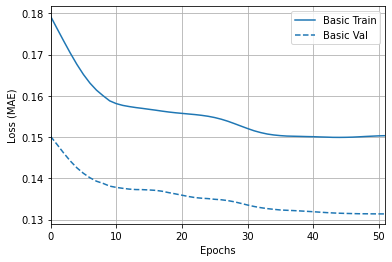

In [89]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric="mae")
plt.ylabel('Loss (MAE)')

## Prediction

In [90]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

14/14 - 0s - loss: 0.1433 - mae: 0.1433 - mse: 0.0342


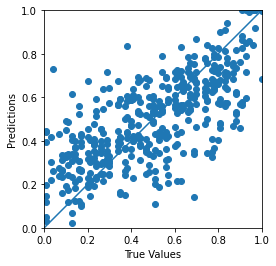

In [91]:
def compare_values(y_true, y_pred):
    a = plt.axes(aspect='equal')
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
y_pred = model.predict(X_test).flatten()
compare_values(y_test, y_pred)

# Regressors

In [107]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

0.14541242057685447


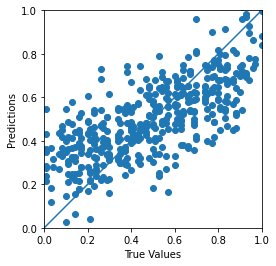

In [120]:
# Linear Regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_test_predict = linreg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

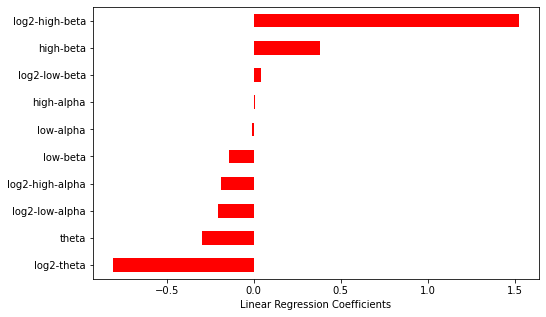

In [121]:
plot_features_weights('Linear Regression', linreg.coef_[0], df.columns[1:], 'c')

0.14613567750570625


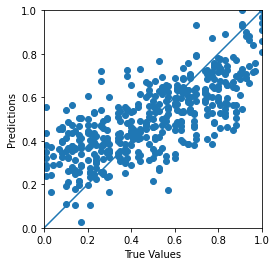

In [118]:
# LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

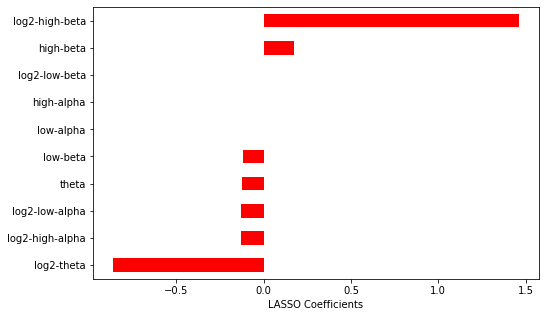

In [119]:
plot_features_weights('LASSO', lasso.coef_, df.columns[1:], 'c')

0.14542425324365463


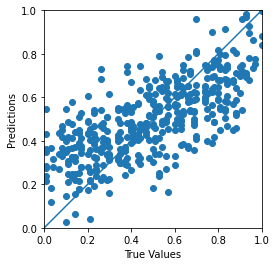

In [122]:
# Ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)
y_test_predict = rdg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

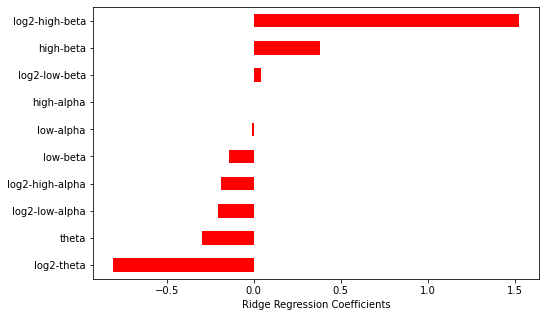

In [123]:
plot_features_weights('Ridge Regression', rdg.coef_[0], df.columns[1:], 'c')

0.15458490971815156


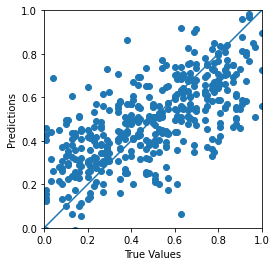

In [97]:
# Polynomial Regression

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)
y_test_predict = polyreg.predict(X_test_poly)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

0.16316917604619383


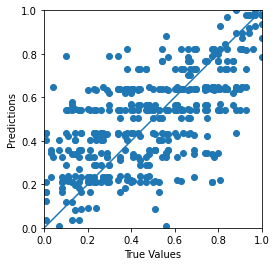

In [98]:
# Decision Tree regression

dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)
y_test_predict = dtrg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

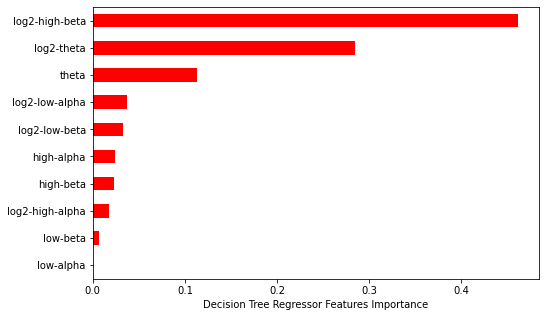

In [124]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, df.columns[1:], 't' )

0.14753583146296304


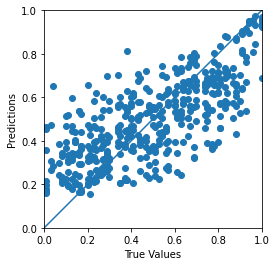

In [94]:
# Ramdom Forest Regressor

rf = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=6, n_jobs=-1, random_state=1)
rf.fit(X_train, np.ravel(y_train))
y_test_predict = rf.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

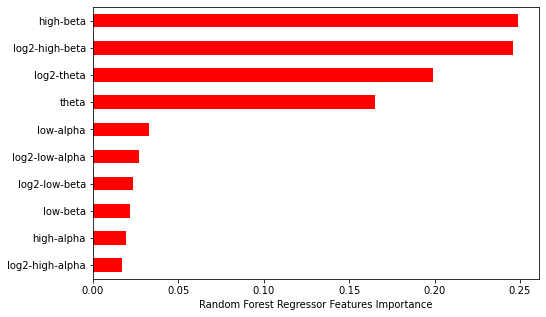

In [125]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, df.columns[1:], 't' )